# NBA Rookie dataset

Sofiene Bourghes - MPData technical interview

## Import library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

RANDOM_SEED = 0

## Load dataset

In [2]:
df = pd.read_csv(".\\nba_logreg.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
Name           1340 non-null object
GP             1340 non-null int64
MIN            1340 non-null float64
PTS            1340 non-null float64
FGM            1340 non-null float64
FGA            1340 non-null float64
FG%            1340 non-null float64
3P Made        1340 non-null float64
3PA            1340 non-null float64
3P%            1329 non-null float64
FTM            1340 non-null float64
FTA            1340 non-null float64
FT%            1340 non-null float64
OREB           1340 non-null float64
DREB           1340 non-null float64
REB            1340 non-null float64
AST            1340 non-null float64
STL            1340 non-null float64
BLK            1340 non-null float64
TOV            1340 non-null float64
TARGET_5Yrs    1340 non-null float64
dtypes: float64(19), int64(1), object(1)
memory usage: 219.9+ KB
None


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [3]:
columns_name = {
    'GP': 'Game Played',
    'MIN': 'MinutesPLayed',
    'PTS': 'PointsPerGame',
    'FGM': 'FieldGoalsMade',
    'FGA': 'FieldGoalsAttempts',
    'FG%': 'FieldGoalPercent',
    '3P Made': '3PointMade',
    '3PA': '3PointAttempts',
    '3P%': '3PointPercent',
    'FTM': 'FreeThrowMade',
    'FTA': 'FreeThrowAttempts',
    'FT%': 'FreeThrowPercent',
    'OREB':'OffensiveRebounds',
    'DREB':'DefensiveRebounds',
    'REB': 'Rebounds',
    'AST': 'Assists',
    'STL': 'Steals',
    'BLK': 'Blocks',
    'TOV': 'Turnovers',
    'TARGET_5Yrs': 'TARGET_5Yrs'
}

## Plot correlation matrix

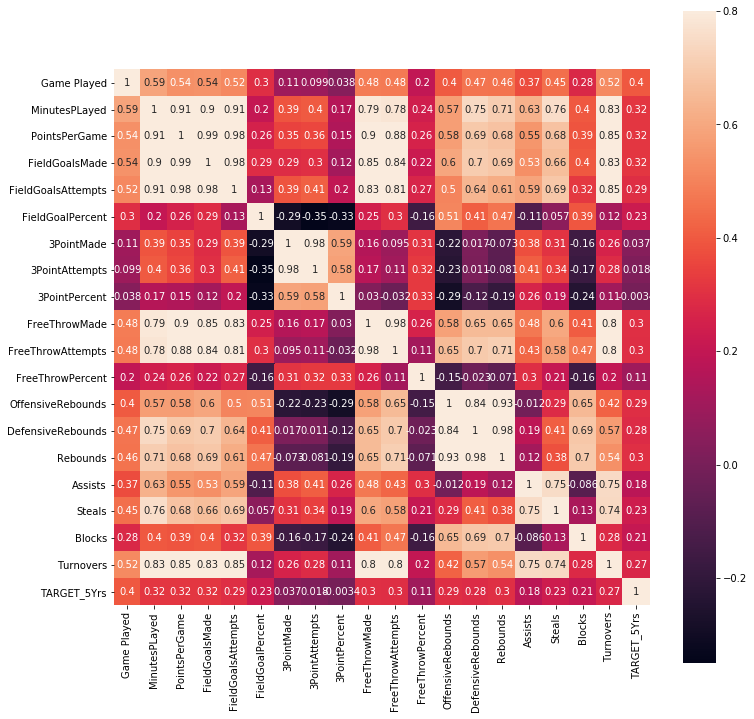

In [4]:
#correlation matrix
df_rename = df.rename(columns=columns_name)
corrmat = df_rename.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

Obviously, a few features are correlated:

* Points per game vs Minutes Played
* Attemps vs Made vs Percent
* etc...

## Plot labels distribution

It's important to check if the dataset is balanced or unbalanced

Label 0: 37.985074626865675 % Label 1: 62.01492537313433 %


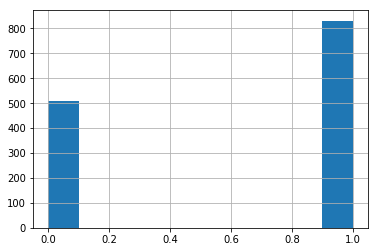

In [5]:
counts = df.TARGET_5Yrs.value_counts().to_dict()
get_percent = lambda x, length : x/length * 100.

print('Label 0:', get_percent(counts[0.0], len(df.TARGET_5Yrs)), '%', 'Label 1:', 
      get_percent(counts[1.0], len(df.TARGET_5Yrs)), '%')

df.TARGET_5Yrs.hist()

## Extract features and label from Dataframe

* Replace NaN value
* Split train/test

In [6]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

In [7]:
# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

In [8]:
# Splitting into training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_vals, labels, test_size = 0.1, random_state = RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1206, 19), (134, 19), (1206,), (134,))

## Normalize features

In [9]:
# normalize dataset - try two different scaler
minmax_scaler = MinMaxScaler().fit(X_train)
X_train_minmax = minmax_scaler.transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

std_scaler = StandardScaler().fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [10]:
# Save scaler for API
# dump(minmax_scaler, 'minmax_scaler.joblib')

In [11]:
# Compute class_weight
from sklearn.utils.class_weight import compute_class_weight

classes = [0, 1]
classes_weight = compute_class_weight('balanced', classes,  labels)

c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0. 0. 0. ... 0. 1. 1.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


## Evaluate base classifier using old score classifier

I've modified the score_classifer function a little bit:

* Use StratifiedKFold instead of KFold to have the same distribution between train and test
* Add seaborn plot for confusion matrix
* Add average classification_report (accuracy, precision, recall, f1 score and support)

Average recall: 0.8302398870127954
Classes precision recall f1 score support
Label 0  -  0.64 0.51 0.57 150
Label 1  -  0.74 0.83 0.78 251


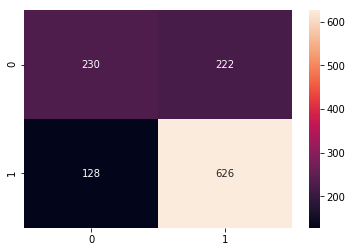

In [12]:
def score_classifier(dataset, classifier, labels):
    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    # StratifiedKFold instead of KFold to have the same distribution between train and test
    kf = StratifiedKFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall_avg = 0.
    rows_avg = []
    for training_ids,test_ids in kf.split(dataset, labels):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall_avg += recall_score(test_labels, predicted_labels)
        # Get classification metrics per class

        p, r, f1, s = precision_recall_fscore_support(test_labels, predicted_labels,
                                              labels=[0, 1],
                                              average=None,
                                              sample_weight=None,
                                              zero_division="warn")

        rows = np.array([p, r, f1, s])
        rows_avg.append(rows)

    recall_avg/=3
    print('Average recall:', recall_avg)
    print('Classes precision recall f1 score support')
    for label, report in zip([0, 1], np.round(np.mean(np.array(rows_avg), axis=0), 2).T):
        p, r, f1, s = report
        print('Label', label, ' - ', p, r, f1, int(s))
    sns.heatmap(confusion_mat, annot=True, fmt='g')

#example of scoring with support vector classifier
score_classifier(X_train_minmax, SVC(), y_train)

Average recall: 0.8209384683488269
Classes precision recall f1 score support
Label 0  -  0.63 0.52 0.57 150
Label 1  -  0.74 0.82 0.78 251


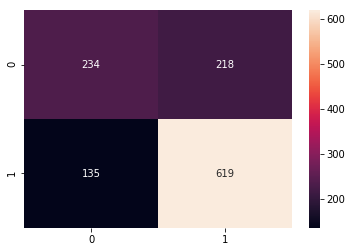

In [13]:
score_classifier(X_train_std, SVC(), y_train)

Average recall: 0.6471890216910138
Classes precision recall f1 score support
Label 0  -  0.55 0.73 0.63 150
Label 1  -  0.8 0.65 0.72 251


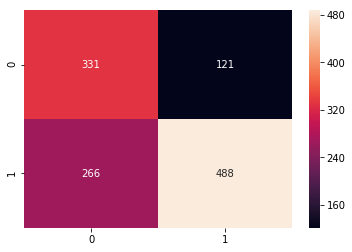

In [14]:
score_classifier(X_train_std,SVC(class_weight='balanced'), y_train)

Average recall: 0.8090178966672991
Classes precision recall f1 score support
Label 0  -  0.61 0.5 0.55 150
Label 1  -  0.73 0.81 0.77 251


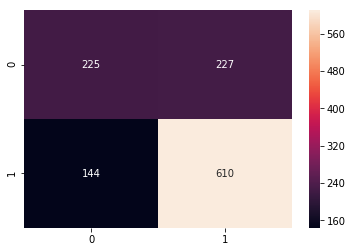

In [15]:
# TODO build a training set and choose a classifier which maximize recall score returned by the score_classifier function
score_classifier(X_train_minmax, RandomForestClassifier(class_weight='balanced'), y_train)

Average recall: 0.806393473724151
Classes precision recall f1 score support
Label 0  -  0.6 0.48 0.53 150
Label 1  -  0.72 0.81 0.76 251


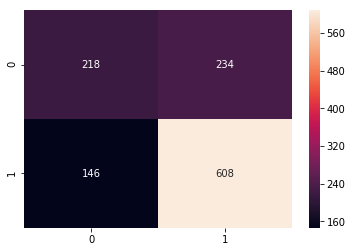

In [16]:
score_classifier(X_train_std, RandomForestClassifier(class_weight='balanced'), y_train)

## Train a few different classifier with Grid Search for Hyperparameter Tuning

* GridSearch already use StratifiedKfold, k=10
* Search the best estimator based on recall scoring function
* Plot confusion matrix and classification report (accuracy, precision, recall, f1 score)

* Try both MinMaxScaler and StandardScaler

In [17]:
def new_score_classifier(classifier, param_grid, X_train, y_train, X_test, y_test):
    clf = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=10, scoring='recall')
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    print(best_params)
    #print(clf.best_estimator_)
    
    y_pred = clf.predict(X_test)
    cf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_mat, annot=True, fmt='g')
    
    print(classification_report(y_test, y_pred, target_names=['0', '1']))
    
    return clf

## Logistic regression

{'class_weight': None, 'dual': False, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.72      0.46      0.56        57
           1       0.68      0.87      0.77        77

    accuracy                           0.69       134
   macro avg       0.70      0.66      0.66       134
weighted avg       0.70      0.69      0.68       134



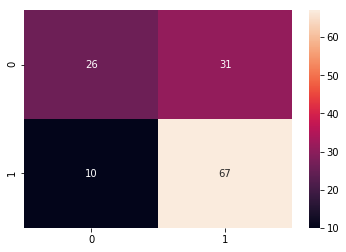

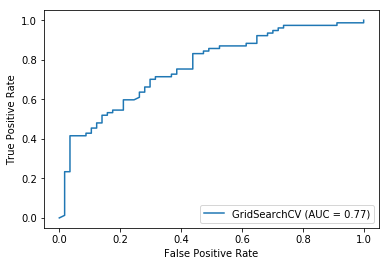

In [18]:
params = {
    'penalty': ['l2'],
    'dual': [False],
    'class_weight': [None, 'balanced'],
    'random_state': [RANDOM_SEED],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf_logistic = new_score_classifier(LogisticRegression(), params, X_train_minmax, y_train, X_test_minmax, y_test)
plot_roc_curve(clf_logistic, X_test_minmax, y_test)

c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\pro

c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\gbour\appdata\local\pro

{'class_weight': None, 'dual': False, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       0.71      0.51      0.59        57
           1       0.70      0.84      0.76        77

    accuracy                           0.70       134
   macro avg       0.70      0.68      0.68       134
weighted avg       0.70      0.70      0.69       134



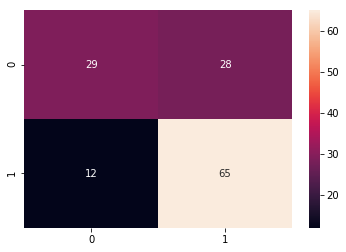

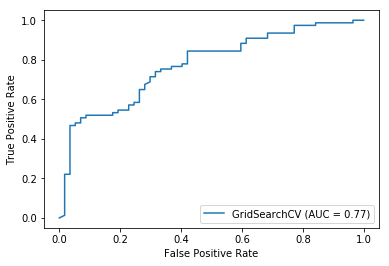

In [31]:
params = {
    'penalty': ['l2'],
    'dual': [False],
    'class_weight': [None, 'balanced'],
    'random_state': [RANDOM_SEED],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf_logistic_std = new_score_classifier(LogisticRegression(), params, X_train_std, y_train, X_test_std, y_test)
plot_roc_curve(clf_logistic_std, X_test_std, y_test)

## K Nearest Neighbors

{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.66      0.47      0.55        57
           1       0.68      0.82      0.74        77

    accuracy                           0.67       134
   macro avg       0.67      0.65      0.65       134
weighted avg       0.67      0.67      0.66       134



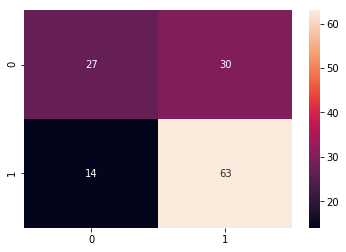

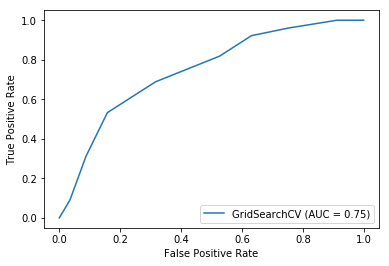

In [20]:
params = {
    'n_neighbors': range(3, 10, 1),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

clf_knn = new_score_classifier(KNeighborsClassifier(), params, X_train_minmax, y_train, X_test_minmax, y_test)
plot_roc_curve(clf_knn, X_test_minmax, y_test)

{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.70      0.49      0.58        57
           1       0.69      0.84      0.76        77

    accuracy                           0.69       134
   macro avg       0.70      0.67      0.67       134
weighted avg       0.70      0.69      0.68       134



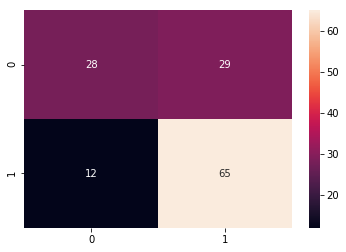

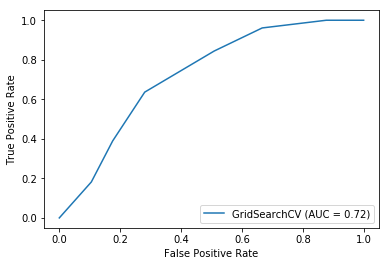

In [21]:
params = {
    'n_neighbors': range(3, 10, 1),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

clf_knn_std = new_score_classifier(KNeighborsClassifier(), params, X_train_std, y_train, X_test_std, y_test)
plot_roc_curve(clf_knn_std, X_test_std, y_test)

## Random Forest

{'class_weight': None, 'max_depth': 8, 'n_estimators': 100, 'random_state': 0}
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        57
           1       0.67      0.82      0.74        77

    accuracy                           0.66       134
   macro avg       0.66      0.64      0.64       134
weighted avg       0.66      0.66      0.65       134



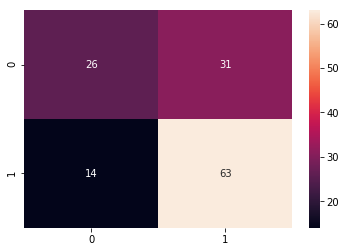

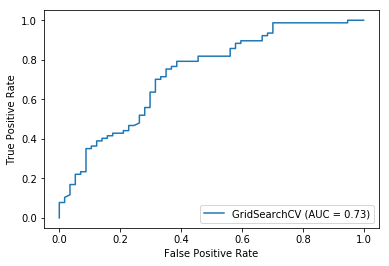

In [22]:
params = {
    'max_depth': range(6, 10, 1),
    'n_estimators': range(50, 200, 10),
    'random_state': [RANDOM_SEED],
    'class_weight': [None, 'balanced']
}

clf_forest = new_score_classifier(RandomForestClassifier(), params, X_train_minmax, y_train, X_test_minmax, y_test)
plot_roc_curve(clf_forest, X_test_minmax, y_test)

{'class_weight': None, 'max_depth': 8, 'n_estimators': 130, 'random_state': 0}
              precision    recall  f1-score   support

           0       0.63      0.46      0.53        57
           1       0.67      0.81      0.73        77

    accuracy                           0.66       134
   macro avg       0.65      0.63      0.63       134
weighted avg       0.65      0.66      0.64       134



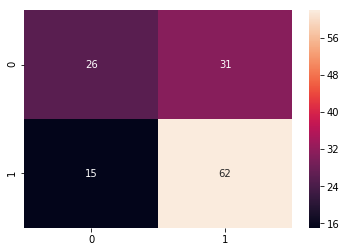

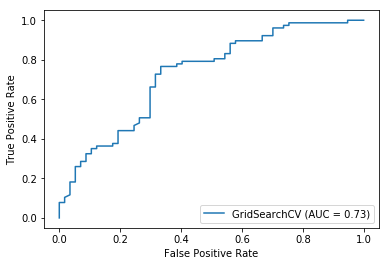

In [23]:
params = {
    'max_depth': range(6, 10, 1),
    'n_estimators': range(50, 200, 10),
    'random_state': [RANDOM_SEED],
    'class_weight': [None, 'balanced']
}

clf_forest = new_score_classifier(RandomForestClassifier(), params, X_train_std, y_train, X_test_std, y_test)
plot_roc_curve(clf_forest, X_test_std, y_test)

In [24]:
# save random forest
# dump(clf_forest, 'clf_forest.joblib')

## Analyse result

Average recall: 0.8342555703113472
Classes precision recall f1 score support
Label 0  -  0.63 0.47 0.53 150
Label 1  -  0.72 0.83 0.77 251


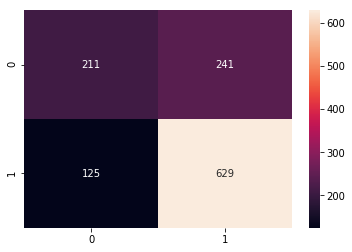

In [35]:
# Logistic regression is the best classifier based on different metrics (accuracy, precision, recall and AUC)
best_estimator = clf_logistic.best_estimator_

# Using score classifier metrics to re evaluate best model with the old metric, don't know if it's usefull
score_classifier(X_train_minmax, best_estimator, y_train)
# This model do sightly better then the SVC() reference 
#score_classifier(X_train_minmax, clf_logistic, y_train)
# Save best estimator (API)
#dump(clf_logistic, 'clf_logistic.joblib')

In [26]:
y_pred = clf_logistic.predict(X_test_minmax)
error_idx = np.argwhere(y_pred != y_test)
print('Number of errors:', len(error_idx),'/', len(y_pred), 'predictions')

Number of errors: 43 / 134 predictions


In [27]:
X_test[error_idx]

array([[[41. ,  5.8,  2.8,  1.2,  2.6, 44.9,  0. ,  0. ,  0. ,  0.4,
          0.7, 66.7,  0.8,  0.9,  1.7,  0.3,  0.2,  0.1,  0.4]],

       [[75. , 26.1,  9.5,  3.6,  9.1, 39.9,  0.9,  2.7, 32.2,  1.4,
          2.1, 64. ,  0.4,  2.2,  2.6,  4.7,  1.1,  0.2,  2.3]],

       [[51. , 15.1,  5.7,  2.2,  5.2, 41.2,  0.3,  0.8, 32.5,  1.1,
          1.6, 69.1,  0.4,  1.3,  1.7,  2.1,  0.7,  0. ,  1.4]],

       [[77. , 15.9,  6.2,  2.7,  5.6, 47.6,  0. ,  0.1, 25. ,  0.8,
          1.1, 73.5,  1.2,  2.1,  3.3,  0.8,  0.3,  0.3,  1.1]],

       [[50. , 21.3,  8.7,  3.1,  7.5, 41.4,  1.2,  3.4, 36.5,  1.2,
          1.6, 76.3,  0.2,  2.2,  2.3,  1.7,  0.6,  0.2,  0.9]],

       [[59. , 23.4,  6.9,  2.8,  7.3, 39.3,  0.4,  1.3, 26.9,  0.8,
          1.1, 79. ,  0.6,  2.1,  2.7,  2.2,  1. ,  0.6,  1.4]],

       [[66. , 22.6,  6.8,  2.9,  5.9, 48.5,  0. ,  0.1, 28.6,  1. ,
          2.3, 44.7,  3. ,  4.3,  7.4,  0.7,  0.5,  0.6,  1.4]],

       [[18. ,  7.9,  1. ,  0.4,  0.8, 53.3,  0. ,  0. 

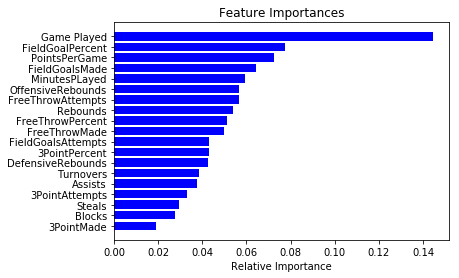

In [28]:
# Display features importances
importance = clf_forest.best_estimator_.feature_importances_
importance_idx = np.argsort(importance)
features = df.drop(['TARGET_5Yrs','Name'],axis=1).columns

plt.title('Feature Importances')
plt.barh(range(len(importance_idx)), importance[importance_idx], color='b', align='center')
plt.yticks(range(len(importance_idx)), [columns_name[features[i]] for i in importance_idx])
plt.xlabel('Relative Importance')
plt.show()

## Try features selection

* by hand
* using dimentionnality reduction algorithm

{'class_weight': None, 'dual': False, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.44      0.54        57
           1       0.68      0.87      0.76        77

    accuracy                           0.69       134
   macro avg       0.70      0.65      0.65       134
weighted avg       0.69      0.69      0.67       134



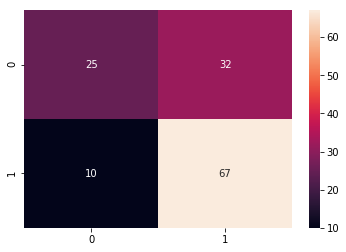

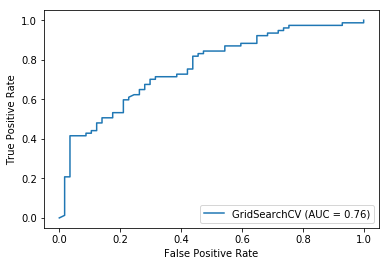

In [29]:
# Feature selection

# try to remove redondant feature by hand

def feature_selections_by_hand():
    names = df['Name'].values.tolist() # players names
    labels = df['TARGET_5Yrs'].values # labels
    paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
    df_vals = df.drop(['3P Made', 'TARGET_5Yrs','Name'],axis=1).values
    
    # replacing Nan values (only present when no 3 points attempts have been performed by a player)
    for x in np.argwhere(np.isnan(df_vals)):
        df_vals[x]=0.0
        
    # Splitting into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(df_vals, labels, test_size = 0.1, random_state = RANDOM_SEED)
    
    # normalize dataset - try two different scaler
    minmax_scaler = MinMaxScaler().fit(X_train)
    X_train_minmax = minmax_scaler.transform(X_train)
    X_test_minmax = minmax_scaler.transform(X_test)
    
    params = {
        'penalty': ['l2'],
        'dual': [False],
        'class_weight': [None, 'balanced'],
        'random_state': [RANDOM_SEED],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    clf_logistic = new_score_classifier(LogisticRegression(), params, X_train_minmax, y_train, X_test_minmax, y_test)
    plot_roc_curve(clf_logistic, X_test_minmax, y_test)
    
feature_selections_by_hand()

{'class_weight': None, 'dual': False, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.44      0.54        57
           1       0.68      0.87      0.76        77

    accuracy                           0.69       134
   macro avg       0.70      0.65      0.65       134
weighted avg       0.69      0.69      0.67       134



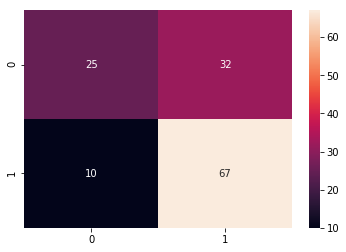

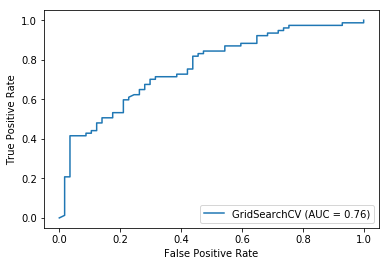

In [30]:
from sklearn.decomposition import PCA

def feature_selections_by_dim_reduction():
    names = df['Name'].values.tolist() # players names
    labels = df['TARGET_5Yrs'].values # labels
    paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
    df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values
    
    # replacing Nan values (only present when no 3 points attempts have been performed by a player)
    for x in np.argwhere(np.isnan(df_vals)):
        df_vals[x]=0.0
        
    # Splitting into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(df_vals, labels, test_size = 0.1, random_state = RANDOM_SEED)
    
    # normalize dataset - try two different scaler
    minmax_scaler = MinMaxScaler().fit(X_train)
    X_train_minmax = minmax_scaler.transform(X_train)
    X_test_minmax = minmax_scaler.transform(X_test)
    
    pca = PCA(n_components=5)
    pca.fit(X_train_minmax)
    
    X_train_pca = pca.transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    
    params = {
        'penalty': ['l2'],
        'dual': [False],
        'class_weight': [None, 'balanced'],
        'random_state': [RANDOM_SEED],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    clf_logistic = new_score_classifier(LogisticRegression(), params, X_train_pca, y_train, X_test_pca, y_test)
    plot_roc_curve(clf_logistic, X_test_pca, y_pca)
    
feature_selections_by_hand()